In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.optim as optims
from torch import nn
import torch.utils.data as Data
import os
import math
import time
from sklearn.linear_model import Lasso,LassoCV, LassoLarsIC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv,yv
torch.set_printoptions(precision=8)
torch.manual_seed(1)
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
torch.set_default_dtype(torch.float64)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['font.sans-serif'] = 'Microsoft YaHei' #'Arial'
plt.rcParams['axes.unicode_minus'] = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#注：程序中的系数h表示论文中的权重参数w

cuda:0


In [22]:
pi = math.pi
torch.manual_seed(1)

#采样边界点
def sample_bd(n=10000):
    x0 = torch.linspace(0,1,n)
    x,y = torch.meshgrid((x0,x0))
    F = (x-0.5)**2+(y-0.5)**2-(0.3+0.1*torch.cos(4*torch.arctan((y-0.5)/(x-0.5))))**2
    x_bd = x[abs(F)<1e-6]
    y_bd = y[abs(F)<1e-6]
    print('采样边界点个数=',x_bd.flatten().shape[0])
    return torch.cat((x_bd.reshape(-1,1),y_bd.reshape(-1,1)),1)
    
#采样内部点
def sample_int(n=300):
    x0 = torch.linspace(0,1,n)
    x,y = torch.meshgrid((x0,x0))
    F = (x-0.5)**2+(y-0.5)**2-(0.3+0.1*torch.cos(4*torch.arctan((y-0.5)/(x-0.5))))**2
    x_int = x[F<1e-6]
    y_int = y[F<1e-6]
    print('采样内点个数=',x_int.flatten().shape[0])
    return torch.cat((x_int.reshape(-1,1),y_int.reshape(-1,1)),1)

#生成训练点和测试点集
def sample_points():
    x_bd_train = sample_bd()
    print('训练的边界点数:',x_bd_train.shape[0])
    x_in_test = sample_int()
    x_bd_test = sample_bd(15000)
    print('测试的边界点和内点数:',x_in_test.shape[0]+x_bd_test.shape[0])
    return x_bd_train,torch.cat((x_in_test,x_bd_test),0)

# def sample_points1():
#     x_in_test = sample_int(30)
#     x_bd_test = sample_bd(15000)
#     print(x_bd_test.shape)
#     x_bd_test = x_bd_test[::5]
#     print(x_bd_test.shape,x_in_test.shape)
#     print('测试的边界点和内点数:',x_in_test.shape[0]+x_bd_test.shape[0])
#     return torch.cat((x_in_test,x_bd_test),0)

x_bd,x_test  = sample_points()
# x_test = sample_points1()

采样边界点个数= 704
训练的边界点数: 704
采样内点个数= 26688
采样边界点个数= 1352
测试的边界点和内点数: 28040
采样内点个数= 256
采样边界点个数= 1352
torch.Size([1352, 2])
torch.Size([271, 2]) torch.Size([256, 2])
测试的边界点和内点数: 527


In [21]:
l_bd = 0.0
r_bd = 1.0

# def Jvs(r):
#     return jv(0,r)

# def Jvs_dr(r):
#     return -jv(1,r)

#0阶第一类贝塞尔函数
def Jvs(r):
    return torch.special.bessel_j0(r)

#0阶第一类贝塞尔函数的导数
def Jvs_dr(r):
    return -torch.special.bessel_j1(r)

def xyToPolar(x,y):
    return torch.sqrt(x**2+y**2)

def xycToPolar(X,c):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    return torch.sqrt((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2+(y.unsqueeze(1)-c[:,1].reshape(-1,1))**2).squeeze(-1)

#SFSNN的网络输出
def get_u(X,c,h):
    r = xycToPolar(X,c)
    Phi = Jvs(k*r)
    u = torch.matmul(Phi,h).reshape(-1,1)
    return u
    
#SFSNN的网络输出对x的导数
def get_u_dx(X,c,h):
    x = X[:,0].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(x.unsqueeze(1)-c[:,0].reshape(-1,1)).squeeze(-1)/r
    u_dx = torch.matmul(Phi,h).reshape(-1,1)
    return u_dx
    
#SFSNN的网络输出对y的导数
def get_u_dy(X,c,h):
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(y.unsqueeze(1)-c[:,1].reshape(-1,1)).squeeze(-1)/r
    u_dy = torch.matmul(Phi,h).reshape(-1,1)
    return u_dy

# def Jvs_drr(r,ksi=0):
#     return 0.5*(Jvs(r,ksi+2)-Jvs(r,ksi))

# def get_u_dxx(X,c,h):
#     x = X[:,0].reshape(-1,1)
#     r = xycToPolar(X,c)
#     r[r == 0] += 1e-9
#     Phi = k*Jvs_drr(k*r,0)*((x.unsqueeze(1)-c[:,0].reshape(-1,1)).squeeze(-1)/r)**2+\
#           Jvs_dr(k*r,0)*(r**2-((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2).squeeze(-1))/r**3
#     u_dxx = k*torch.matmul(Phi,h).reshape(-1,1)
#     return u_dxx
    
# def get_u_dyy(X,c,h):
#     y = X[:,1].reshape(-1,1)
#     r = xycToPolar(X,c)
#     r[r == 0] += 1e-9
#     Phi = k*Jvs_drr(k*r,0)*((y.unsqueeze(1)-c[:,1].reshape(-1,1)).squeeze(-1)/r)**2+\
#           Jvs_dr(k*r,0)*(r**2-((y.unsqueeze(1)-c[:,1].reshape(-1,1))**2).squeeze(-1))/r**3
#     u_dxx = k*torch.matmul(Phi,h).reshape(-1,1)
#     return u_dxx

#SFSNN的网络输出对参数c的梯度
def get_u_dc(X,c,h):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi_1 = k*h*Jvs_dr(k*r)*(c[:,0].reshape(-1,1)-x.unsqueeze(1)).squeeze(-1)/r
    Phi_2 = k*h*Jvs_dr(k*r)*(c[:,1].reshape(-1,1)-y.unsqueeze(1)).squeeze(-1)/r
    return torch.cat((Phi_1.unsqueeze(-1),Phi_2.unsqueeze(-1)),-1)
    
#SFSNN的网络输出对权重参数h的梯度
def get_u_dh(X,c):
    r = xycToPolar(X,c)
    Phi = Jvs(k*r)   #m*n
    return Phi

#解析解的波源
exact_center = torch.tensor([[1.0,1.0]],dtype=torch.float64)
exact_hight = torch.tensor([1.0],dtype=torch.float64)

#定义解析解
def u_exact(X):
    r = xycToPolar(X,exact_center)
    Phi = yv(0,k*r)
    u = torch.matmul(Phi,exact_hight).reshape(-1,1)
    if X.is_cuda:
        u = u.to(device)
    return u

#定义解析解对x的导数
def u_dx_exact(X):
    x = X[:,0].reshape(-1,1)
    r = xycToPolar(X,exact_center)
    r[r == 0] += 1e-15
    Phi = -k*yv(1,k*r)*(x.unsqueeze(1)-exact_center[:,0].reshape(-1,1)).squeeze(-1)/r
    u_dx = torch.matmul(Phi,exact_hight).reshape(-1,1)
    if X.is_cuda:
        u_dx = u_dx.to(device)
    return u_dx

#定义解析解对y的导数
def u_dy_exact(X):
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,exact_center)
    r[r == 0] += 1e-15
    Phi = -k*yv(1,k*r)*(y.unsqueeze(1)-exact_center[:,1].reshape(-1,1)).squeeze(-1)/r
    u_dy = torch.matmul(Phi,exact_hight).reshape(-1,1)
    if X.is_cuda:
        u_dy = u_dy.to(device)
    return u_dy


#生成边界控制项
def generate_bd_term(x_bd):
    g = u_exact(x_bd)  #迪利克雷边界项
    return g


#计算相对误差
def test_err(net):
    X = x_test.clone()
    u_ex = u_exact(X).flatten()
    u_dx_ex = u_dx_exact(X).flatten()
    u_dy_ex = u_dy_exact(X).flatten()
    u_ex = u_ex.to(device)
    u_dx_ex = u_dx_ex.to(device)
    u_dy_ex = u_dy_ex.to(device)
    net = net.to(device)
    if net.hight.shape[0]>3000:
        use_batch=True
    else:
        use_batch=False
    with torch.no_grad():
        if use_batch:
            dataset = Data.TensorDataset(X)
            data_iter = Data.DataLoader(dataset=dataset, batch_size=2000, shuffle=False)
            u = None
            u_dx = None
            u_dy = None
            for x in data_iter:
                x_part = x[0].to(device)
                u_part = net(x_part).flatten()
                u_dx_part = net.cal_dx(x_part).flatten()
                u_dy_part = net.cal_dy(x_part).flatten()
                if u is None:
                    u = u_part
                    u_dx = u_dx_part
                    u_dy = u_dy_part
                else:
                    u = torch.cat((u,u_part),0)
                    u_dx =  torch.cat((u_dx,u_dx_part),0)
                    u_dy =  torch.cat((u_dy,u_dy_part),0)
                torch.cuda.empty_cache()
        else:
            X = X.to(device)
            u = net(X).flatten()
            u_dx = net.cal_dx(X).flatten()
            u_dy = net.cal_dy(X).flatten()
    Rel_L2 = torch.norm(u_ex-u)/torch.norm(u_ex)  
    Rel_Li = torch.max(torch.abs(u-u_ex))/torch.max(torch.abs(u_ex))
    Rel_H1 = torch.sqrt(torch.norm(u_ex-u)**2+torch.norm(u_dx_ex-u_dx)**2+torch.norm(u_dy_ex-u_dy)**2)/\
                torch.sqrt(torch.norm(u_ex)**2+ torch.norm(u_dx_ex)**2+torch.norm(u_dy_ex)**2)
    print("Rel.L2=",Rel_L2.cpu(),",Rel.Li=",Rel_Li.cpu(),",Rel.H1=",Rel_H1.cpu())
    losswriter.add_scalar('Rel_L2',Rel_L2.cpu().item())
    losswriter.add_scalar('Rel_Li',Rel_Li.cpu().item())
    losswriter.add_scalar('Rel_H1',Rel_H1.cpu().item())
    return Rel_L2,Rel_Li,Rel_H1


#去除无效基函数
def drop_bf(net,tol=10):
    if tol>1:
        if tol>=net.hight.data.shape[0]:
            return net
        net = net.cpu()
        print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
        c, h = net.center.detach(), net.hight.detach()
        top_values, index = torch.topk(abs(h), k=tol, largest=True)
        c1 = torch.index_select(c, 0, index)
        h1 = torch.index_select(h, 0, index)
        net.center = nn.Parameter(c1)
        net.hight = nn.Parameter(h1)
        print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    else:
        net = net.cpu()
        print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
        c, h = net.center.detach(), net.hight.detach()
        index = torch.where(abs(h) > tol)[0]
        c1 = torch.index_select(c, 0, index)
        h1 = torch.index_select(h, 0, index)
        net.center = nn.Parameter(c1)
        net.hight = nn.Parameter(h1)
        print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    return net

#初始化中心分布
def generate_center(N):
    n = int(math.sqrt(N))
    x0 = torch.linspace(0,1,n)
    mx,my = torch.meshgrid((x0,x0))
    center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    # if N >n**2:
    #     c1 = torch.rand(N-n**2,2)
    #     center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    #     center = torch.cat((center,c1),0)
    return center

#定义SFSNN网络
class BesselNet(torch.nn.Module):
    def __init__(self,N=32):
        super(BesselNet, self).__init__()
        torch.manual_seed(1)
        # self.center = nn.Parameter((r_bd-l_bd)*torch.rand(N,2)+l_bd)
        # self.center = nn.Parameter(calculate_circle_coordinates(N,2))
        self.center = nn.Parameter(generate_center(N))
        self.hight = nn.Parameter(torch.rand(N,dtype=torch.float64))

    def forward(self, x):
        u = get_u(x,self.center,self.hight)
        return u

    def cal_dx(self,x):
        return get_u_dx(x,net.center,net.hight)

    def cal_dy(self,x):
        return get_u_dy(x,net.center,net.hight)

#计算每个基函数在边界采样点上的值，即论文中LASSO问题的系数矩阵A和右端项两f
def cal_Jacobi(net,x_bd):
    with torch.no_grad():
        A = get_u_dh(x_bd,net.center.data)
        f = generate_bd_term(x_bd)
    print('A.shape',A.shape,f.shape)
    return A.detach(),f.detach()

#最小二乘求解Ax=f
def solve_coeff(net,A,f):  #solve  Ax=f
    test_err(net)
    net = net.cpu()
    print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    t1 = time.time()
    
    bestP = torch.linalg.lstsq(A,f,driver='gelsd')[0] #‘gels’ , ‘gelsy’ , ‘gelsd , ‘gelss’
    t2 = time.time()
    print("solve time=",t2-t1)
    net.hight = nn.Parameter(bestP.flatten())
    print("admm优化后,err_norm=",torch.norm(torch.matmul(A,bestP).reshape(-1,1)-f))
    print("admm优化后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

#记录损失
class LossWriter:
    def __init__(self, filename):
        self.filename = filename
        self.data = {}

    def add_scalar(self, tag, scalar_value):
        if tag not in self.data:
            self.data[tag] = []
        self.data[tag].append(scalar_value)
        
    def save(self):
        # 保存数据为npz格式
        np.savez(self.filename, **self.data)


#求解LASSO问题：||Ax-f||+\lam||x||_1
def solve_coeff_lasso(net,A,f,lam=0.001,cri=None):  #solve  Ax=f
    # test_err(net)
    net = net.cpu()
    # print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    if cri=='aic':
        clf = LassoLarsIC('aic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用aic,最佳的lam=',clf.alpha_)
    elif cri=='bic':
        clf = LassoLarsIC('bic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用bic,最佳的lam=',clf.alpha_)
    else:
        clf = Lasso(lam,fit_intercept=False)
        clf.fit(A,f) 
        print('使用指定的lam=',lam)
    h = torch.tensor(clf.coef_)
    net.hight = nn.Parameter(h.flatten())
    print("admm优化后,err_norm=",torch.norm(torch.matmul(A,h).reshape(-1,1)-f))
    print("admm优化后,相对误差:")
    # test_err(net)
    net = net.to(device)
    return net

基函数个数= 1600
A.shape torch.Size([704, 1600]) torch.Size([704, 1])
初始有效基函数个数= 1600
初始误差,err_norm= tensor(24.44495957)


/home/wzw/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.192e-03, tolerance: 1.580e-04
  model = cd_fast.enet_coordinate_descent(


使用指定的lam= 1e-06
admm优化后,err_norm= tensor(0.01187024)
admm优化后,相对误差:
The number of RBFs before discarding：1600
The number of RBFs after discarding：194
总基函数个数: 194 绘制前6个基函数


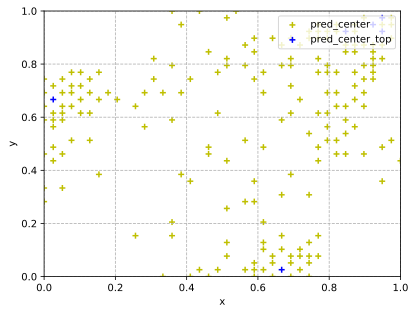

Rel.L2= tensor(0.02513149) ,Rel.Li= tensor(0.05457186) ,Rel.H1= tensor(0.02567936)
k=200,t_all=0.003,t_Niter=0.003,Niter:1,l_bd:0.00020859,lr:0.01000000
k=200,t_all=0.005,t_Niter=0.002,Niter:2,l_bd:5.18139066,lr:0.01000000
k=200,t_all=0.008,t_Niter=0.002,Niter:3,l_bd:1.57348404,lr:0.01000000
k=200,t_all=0.010,t_Niter=0.002,Niter:4,l_bd:2.17289206,lr:0.01000000
k=200,t_all=0.012,t_Niter=0.002,Niter:5,l_bd:1.28590328,lr:0.01000000
k=200,t_all=0.015,t_Niter=0.002,Niter:6,l_bd:0.68651996,lr:0.01000000
k=200,t_all=0.017,t_Niter=0.002,Niter:7,l_bd:0.66296366,lr:0.01000000
k=200,t_all=0.019,t_Niter=0.002,Niter:8,l_bd:0.53233118,lr:0.01000000
k=200,t_all=0.022,t_Niter=0.002,Niter:9,l_bd:0.45861689,lr:0.01000000
k=200,t_all=0.024,t_Niter=0.002,Niter:10,l_bd:0.37025378,lr:0.01000000
center变动最大的: 0.009914544547706572
hight中变动最大的: 0.00886429976779178
k=200,t_all=0.026,t_Niter=0.002,Niter:11,l_bd:0.28646219,lr:0.01000000
k=200,t_all=0.029,t_Niter=0.002,Niter:12,l_bd:0.19487202,lr:0.01000000
k=200,t

BesselNet()

In [22]:
def caldc(c1,c2):
    dc = (abs(c1-c2)).sum(-1)
    print("center变动最大的:",torch.max(dc).cpu().item())

def caldh(h1,h2):
    print("hight中变动最大的:",torch.max(abs(h1-h2)).cpu().item())

#合并基函数
def merge_bf(center,hight,tol=0.01):
    distances = torch.cdist(center,center)
    # print(distances)
    c_new,h_new = [],[]
    index = torch.arange(distances.shape[0])
    i = 0
    while (len(index)>0)&(i<hight.shape[0]):
        dis = distances[i,:]
        index_i = torch.where(dis<tol)[0]
        c = 0
        h = 0
        # print('i=',i,'dis=',dis)
        num= len(index)
        for j in index_i:
            if j not in index:
                continue
            c += center[j,:]
            h += hight[j]
            if len(index)==1:
                index= []
            else:
                index_del = np.where(index==j)
                index = np.delete(index,index_del) 
            # print('j=',j,'index=',index)
        # print(min(len(index_i),num))
        # print('c1=',c/min(len(index_i),num),'h1=',h)
        c_new.append(c/min(len(index_i),num))
        h_new.append(h)
        # print('index=',index,len(index))
        if len(index)>0:
            i = index[0]
        else:
            i = i+1
    c_new = torch.tensor(np.array(c_new))
    h_new = torch.tensor(np.array(h_new))
    print('合并前的中心=',center,'合并前的系数=',hight)
    print('合并后的中心=',c_new,'合并后的系数=',h_new)
    return c_new,h_new
    
#训练SFSNN网络
def train(net,x_bd,losswriter,lr,MaxNiter,lam,tol,tol_c):
    t_all = 0.0
    test_err(net)
    g = generate_bd_term(x_bd)   #边界控制项
    g = g.to(device)
    net = net.to(device)
    optimizer = optims.Adam([{"params":net.center,"lr":lr},{"params":net.hight,"lr":lr}])
    x_bd = x_bd.to(device)
    for Niter in range(1, MaxNiter):
        l_bd_sum = 0.0
        t1 = time.time()
        optimizer.zero_grad()
        with torch.no_grad():
            u_bd = get_u(x_bd,net.center,net.hight)  
            u_bd_dc = get_u_dc(x_bd,net.center,net.hight)
            u_bd_dh = get_u_dh(x_bd,net.center)
        c1 = net.center.clone()
        h1 = net.hight.clone()
        l_bd = ((u_bd-g)**2).sum() 
        net.center.grad = (2*(u_bd-g).unsqueeze(-1)*u_bd_dc).sum(0)
        net.hight.grad = (2*(u_bd-g)*u_bd_dh).sum(0)
        optimizer.step()
        c2 = net.center.data
        h2 = net.hight.data
       
        t2 = time.time()
        t_all += t2-t1
        if (Niter%200==0)&(optimizer.param_groups[0]['lr']>=0.0001):
            for i in range(len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr']=0.1*optimizer.param_groups[i]['lr']
        print('k=%d,t_all=%.3f,t_Niter=%.3f,Niter:%d,l_bd:%.8f,lr:%.8f' 
            % (k,t_all,t2-t1, Niter, l_bd.cpu().item(),optimizer.param_groups[0]['lr']))
        losswriter.add_scalar('loss', l_bd.cpu().item())
        if Niter%10==0:
            torch.save(net.state_dict(), 'model/2d_exam0_%d.pth'%int(k))
            # test_err(net)
            losswriter.save()
            caldc(c1,c2)
            caldh(h1,h2)
            # print('center=',net.center.data,'hight=',net.hight.data)
            # plot_center(net)
            losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
            
        if (Niter%7000==0)&(net.hight.shape[0]>1)&(Niter<MaxNiter-500):
            net = net.cpu()
            net = drop_bf(net,tol)
            center_new,hight_new = merge_bf(net.center.data,net.hight.data,tol_c)
            net.center = nn.Parameter(center_new)
            net.hight = nn.Parameter(hight_new)
            A,f = cal_Jacobi(net,x_bd.cpu())
            net = solve_coeff_lasso(net,A,f,lam)
            net = drop_bf(net,tol)
            # plot_center(net)
            print('center=',net.center.data,'hight=',net.hight.data)
            net = net.to(device)
            optimizer = optims.Adam([{"params":net.center,"lr":lr},\
                                     {"params":net.hight,"lr":lr}])
    net = net.cpu()
    x_bd = x_bd.cpu()
    A,f = cal_Jacobi(net,x_bd)
    net = solve_coeff(net,A,f)
    torch.save(net.state_dict(), 'model/2d_exam4_%d.pth'%int(k))
    test_err(net)
    losswriter.save()
    # plot_center(net,save_path='imgs/2d_exam4/k_%d_final_center.png'%k)
    return net

#绘制基函数的中心分布
def plot_center(net,num=6,save_path=None):
    # index = torch.where(abs(net.hight.data.cpu()) > 1e-5)[0]
    top_values, index = torch.topk(abs(net.hight.data.cpu()), k=num, largest=True)
    # print('前8个基函数系数=',top_values,',所有系数=',net.hight.data.cpu())
    print('总基函数个数:',net.hight.shape[0],'绘制前%d个基函数'%num)
    plt.grid(linestyle="--")
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.scatter(exact_center[:,0],exact_center[:,1],c='r',marker='o',label='exact_center')
    blue_label_added = False
    yellow_label_added = False
    for i in range(len(net.hight.data.cpu())):
        if i in index:
            if not blue_label_added:
                plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],c='b',marker='+',label='pred_center_top')
                blue_label_added = True
            else:
                plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],c='b',marker='+')
        else:
            if not yellow_label_added:
                plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],c='y',marker='+',label='pred_center')
                yellow_label_added = True
            else:
                plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],c='y',marker='+')
    
    plt.legend(loc='upper right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def load_model(net):
    model = torch.load('model/2d_exam4_%d.pth'%int(k))
    net.center = nn.Parameter(model['center'])
    net.hight = nn.Parameter(model['hight'])
    return net

k = 200
lr = 0.01
MaxNiter = 800
n_bd = 1000
N = int(k/5)**2
tol = 0.001
tol_c = 0.5/k
torch.manual_seed(1)
lam = 0.000001#0.1,0.01,,0.0001,0.00001,0.000001
device = 'cuda:0'


net = BesselNet(N)
losswriter = LossWriter('loss/loss_exam4_%d_%d.npz'%(k,N))
losswriter.add_scalar('k',k)
losswriter.add_scalar('MaxNiter',MaxNiter)
losswriter.add_scalar('n_bd',n_bd)
losswriter.add_scalar('lr',lr)
losswriter.add_scalar('N',N)
losswriter.add_scalar('lam',lam)
losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
losswriter.add_scalar('tol',tol)
losswriter.add_scalar('tol_c',tol_c)

# net = load_model(net)
net = net.cpu()
print('基函数个数=',net.hight.data.shape[0])
A,f = cal_Jacobi(net,x_bd)
# net = solve_coeff(net,A,f)
# test_err(net)
net = solve_coeff_lasso(net,A,f,lam)#
net = drop_bf(net,tol)
torch.save(net.state_dict(), 'model/2d_exam4_%d_init.pth'%int(k))
# L2,_,_= test_err(net)
# print('lam=',lam,',L2=',L2)
plot_center(net,save_path='imgs/2d_exam4/k_%d_init_center.png'%k)
train(net,x_bd,losswriter,lr,MaxNiter,lam,tol,tol_c)


#下面使用MFS方法对比#

In [23]:
class BesselNet(torch.nn.Module):
    def __init__(self,N=32):
        super(BesselNet, self).__init__()
        torch.manual_seed(1)
        self.center = nn.Parameter((r_bd-l_bd)*torch.rand(N,2)+l_bd)
        # self.center = nn.Parameter(calculate_circle_coordinates(N,2))
        # self.center = nn.Parameter(generate_center(N))
        self.hight = nn.Parameter(torch.rand(N,dtype=torch.float64))

    def forward(self, x):
        u = get_u(x,self.center,self.hight)
        return u

    def cal_dx(self,x):
        return get_u_dx(x,net.center,net.hight)

    def cal_dy(self,x):
        return get_u_dy(x,net.center,net.hight)

net = BesselNet(194)
A,f = cal_Jacobi(net,x_bd)
net = solve_coeff(net,A,f)
test_err(net)

A.shape torch.Size([704, 194]) torch.Size([704, 1])
Rel.L2= tensor(13.49881434) ,Rel.Li= tensor(27.59717859) ,Rel.H1= tensor(13.41918928)
A的条件数= tensor(65779308.44536849)
初始有效基函数个数= 194
初始误差,err_norm= tensor(17.22225804)
solve time= 0.008489608764648438
admm优化后,err_norm= tensor(3.33487971e-07)
admm优化后,相对误差:
Rel.L2= tensor(6.60092917e-07) ,Rel.Li= tensor(2.96681664e-06) ,Rel.H1= tensor(6.56248910e-07)
Rel.L2= tensor(6.60092917e-07) ,Rel.Li= tensor(2.96681664e-06) ,Rel.H1= tensor(6.56248910e-07)


(tensor(6.60092917e-07, device='cuda:0'),
 tensor(2.96681664e-06, device='cuda:0'),
 tensor(6.56248910e-07, device='cuda:0'))

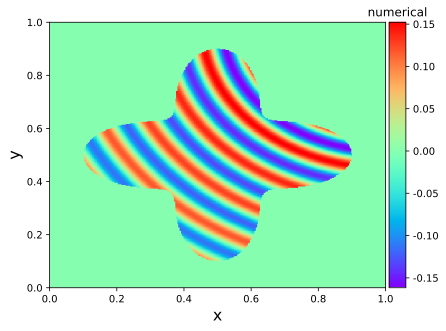

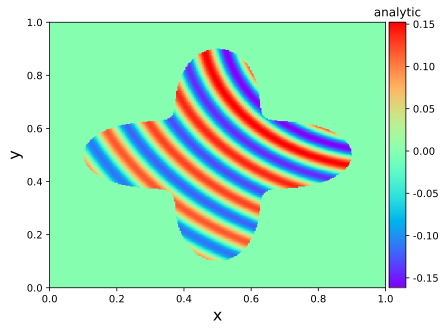

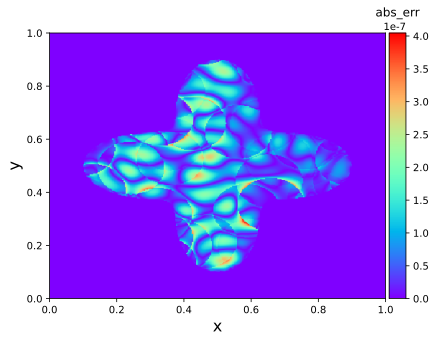

Rel.L2= tensor(1.10770803e-06) ,Rel.Li= tensor(2.50236503e-06) ,Rel.H1= tensor(1.10888626e-06)


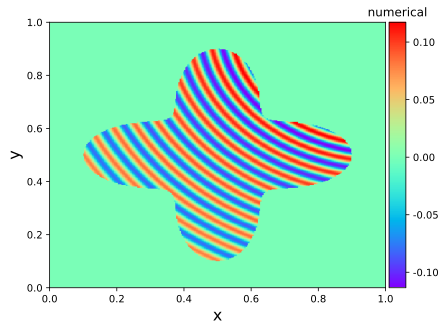

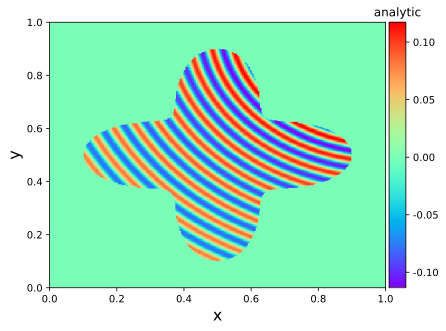

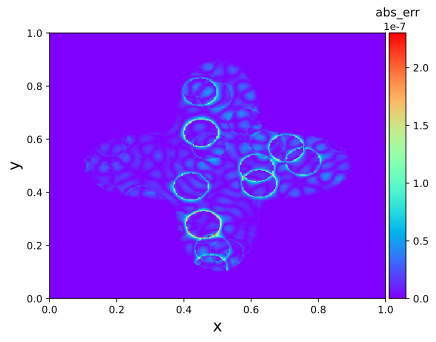

Rel.L2= tensor(3.67045825e-07) ,Rel.Li= tensor(1.96268286e-06) ,Rel.H1= tensor(3.26761619e-07)


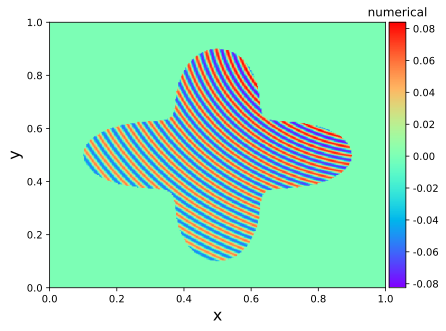

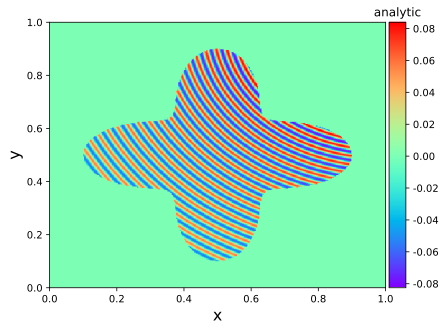

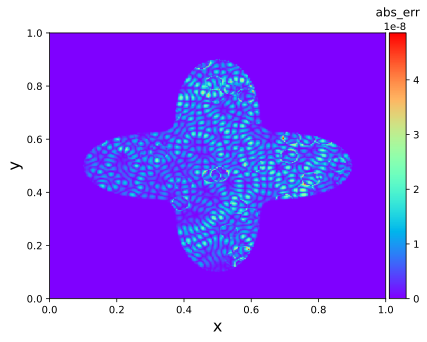

Rel.L2= tensor(1.70785008e-07) ,Rel.Li= tensor(5.78591340e-07) ,Rel.H1= tensor(1.73488407e-07)


(tensor(1.70785008e-07, device='cuda:0'),
 tensor(5.78591340e-07, device='cuda:0'),
 tensor(1.73488407e-07, device='cuda:0'))

In [26]:
k=50
net = load_model(net)
test_plot(net,'imgs/2d_exam4/')
test_err(net)
k=100
net = load_model(net)
test_plot(net,'imgs/2d_exam4/')
test_err(net)
k=200
net = load_model(net)
test_plot(net,'imgs/2d_exam4/')
test_err(net)

In [25]:
#绘制绝对误差图像
def test_plot(net,save_path=None,n=300):
    x0 = torch.linspace(l_bd, r_bd, n,dtype=torch.float64)
    mx, my = torch.meshgrid(x0, x0)
    F = (mx-0.5)**2+(my-0.5)**2-(0.3+0.1*torch.cos(4*torch.arctan((my-0.5)/(mx-0.5))))**2
    net = net.cpu()
    with torch.no_grad():
        X = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
        u = net(X).reshape(-1,n).T
        u_ex = u_exact(X).reshape(-1,n).T
    u[F>1e-6] = 0
    u_ex[F>1e-6] = 0
    plot_sol(u,"numerical",save_path+'/k_%d_u.png'%k)
    plot_sol(u_ex,"analytic",save_path+'/k_%d_u_ex.png'%k)
    plot_sol(abs(u-u_ex),"abs_err",save_path+'/k_%d_u_err.png'%k)
    
    
def plot_sol(u,title,save_path):
    plt.figure()
    ax =  plt.subplot(1,1,1)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    h = plt.imshow(u, interpolation='nearest', cmap='rainbow',
                   extent=[l_bd, r_bd, l_bd, r_bd],
                   origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax) 
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
def show_slice(val = 0,show_x=True,n=500):
    if show_x:
        x = torch.linspace(l_bd,r_bd,n,dtype=torch.float64)
        y = val*torch.ones_like(x,dtype=torch.float64)
        r = xyToPolar(x,y)
        u_ex = u_exact(torch.cat((x.reshape(-1,1),y.reshape(-1,1)),1))
        with torch.no_grad():
            u = get_u(torch.cat((x.reshape(-1,1),y.reshape(-1,1)),1),net.center,net.hight)
        plt.plot(x.flatten(),u.flatten())
        plt.plot(x.flatten(),u_ex.flatten())
        plt.xlabel("x")
        plt.ylabel("u")
        plt.title("y=%.3f"%val)
        plt.legend(["nn","exact"])
        plt.show()
    else:
        y = torch.linspace(l_bd,r_bd,n,dtype=torch.float64)
        x = val*torch.ones_like(y,dtype=torch.float64)
        r = xyToPolar(x,y)
        u_ex = u_exact(torch.cat((x.reshape(-1,1),y.reshape(-1,1)),1))
        with torch.no_grad():
            u = get_u(torch.cat((x.reshape(-1,1),y.reshape(-1,1)),1),net.center,net.hight)
        plt.plot(y.flatten(),u.flatten())
        plt.plot(y.flatten(),u_ex.flatten())
        plt.xlabel("y")
        plt.ylabel("u")
        plt.title("x=%.3f"%val)
        plt.legend(["nn","exact"])
        plt.show()

# test_plot(net)
# show_slice(0)
# show_slice(1)
# show_slice(0,False)
# show_slice(1,False)